In [129]:
from collections import deque
from collections import defaultdict
import numpy as np
import random

### Daily update of edge queue

In [217]:
def dailyUpdateEdgeQueue(edge_map, D = 14):
    for edge_key in edge_map:
        edge_queue = edge_map[edge_key]
        edge_queue = deque([day_val + 1 for day_val in edge_queue])
        if edge_queue[0] > D:
            edge_queue.popleft()
        edge_map[edge_key] = edge_queue
        # check if the queue is empty => edge needs to be deleted
        if len(edge_queue) == 0:
            deleteEdge(edge_key)
            del edge_map[edge_key]

    return edge_map

In [131]:
que1 = deque([3, 2])
que2 = deque([4, 1])
edge_map = {'key1': que1, 'key2': que2}

In [132]:
dailyUpdateEdgeQueue(edge_map)

{'key1': deque([4, 3]), 'key2': deque([5, 2])}

### Daily update of adjacency list based on the interactions

In [133]:
def updateAdjacencyList(interaction_data, edge_map, adj_list):
    for pair in interaction_data:
        p1, p2 = pair
        key = p1 + '_' + p2
        #print(key)
        
        # if p1, p3 edge was not present - as its undirected graph, if p2 not present in adj list of p1
        # the vice versa applies
        edge_present = 0
        # if edge is present - just update the edge_queue to add today's interaction
        for neighbor in adj_list[p1]:
            neighb, edge_key = neighbor
            if neighb == p2:
                edge_present = 1
                edge_map[edge_key].append(1)
        # if edge is not present, then add the edge and create the edge_key
        if edge_present != 1:
            edge_map[key] = deque([1])
            adj_list[p1].append((p2, key))
            adj_list[p2].append((p1, key))
            
    return adj_list, edge_map

### Testing the above functions for 2 days

In [134]:
adj_list = defaultdict(list)
edge_map = defaultdict()

interaction_data = [('u1', 'u2'), ('u1', 'u3'), ('u3', 'u4')]
adj_list, edge_map = updateAdjacencyList(interaction_data, edge_map, adj_list)

In [135]:
adj_list

defaultdict(list,
            {'u1': [('u2', 'u1_u2'), ('u3', 'u1_u3')],
             'u2': [('u1', 'u1_u2')],
             'u3': [('u1', 'u1_u3'), ('u4', 'u3_u4')],
             'u4': [('u3', 'u3_u4')]})

In [136]:
edge_map

defaultdict(None,
            {'u1_u2': deque([1]), 'u1_u3': deque([1]), 'u3_u4': deque([1])})

In [137]:
dailyUpdateEdgeQueue(edge_map)

defaultdict(None,
            {'u1_u2': deque([2]), 'u1_u3': deque([2]), 'u3_u4': deque([2])})

In [138]:
interaction_data = [('u1', 'u5'), ('u1', 'u3')]
adj_list, edge_map = updateAdjacencyList(interaction_data, edge_map, adj_list)

In [139]:
edge_map

defaultdict(None,
            {'u1_u2': deque([2]),
             'u1_u3': deque([2, 1]),
             'u3_u4': deque([2]),
             'u1_u5': deque([1])})

In [140]:
adj_list

defaultdict(list,
            {'u1': [('u2', 'u1_u2'), ('u3', 'u1_u3'), ('u5', 'u1_u5')],
             'u2': [('u1', 'u1_u2')],
             'u3': [('u1', 'u1_u3'), ('u4', 'u3_u4')],
             'u4': [('u3', 'u3_u4')],
             'u5': [('u1', 'u1_u5')]})

### Deleting an edge if edge queue becomes empty

In [141]:
def deleteEdge(edge_key, adj_list):
    p1, p2 = edge_key.split('_')
    adj_list[p1].remove((p2, edge_key))
    adj_list[p2].remove((p1, edge_key))
    
    return adj_list

In [142]:
deleteEdge('u1_u2', adj_list)

defaultdict(list,
            {'u1': [('u3', 'u1_u3'), ('u5', 'u1_u5')],
             'u2': [],
             'u3': [('u1', 'u1_u3'), ('u4', 'u3_u4')],
             'u4': [('u3', 'u3_u4')],
             'u5': [('u1', 'u1_u5')]})

In [143]:
def getInfectedIndList(infected_map):
    infected_list = []
    for uid in infected_map:
        infected_list.append(uid)
        
    return infected_list

In [144]:
infected_map = {'u1': ['Name', 1, 10], 'u2': ['Name', 0, 9]}

infected_list = getInfectedIndList(infected_map)

### Checking the edge queues to trace indirect contacts possible infection

In [145]:
def indirectContactTrace(key1, key2, edge_map):
    # edge queue between parent and its parent
    queue1 = edge_map[key1]
    
    # edge queue between current vertex and its parent
    queue2 = edge_map[key2]
    
    max_q1 = queue1[0]
    min_q2 = queue2[-1]
    
    # This means that there is no infection
    if max_q1 < min_q2:
        return False
    
    return True

### BFS to trace possibly infected people

In [146]:
def tracingBFS(infected_list, adj_list, edge_map):
    visited = []
    possible_infected = []
    possible_infected_with_severity = []
    bfs_queue = deque()
    level = 1
    
    # Insert the list of all direct contacts of the infected people to the queue
    for vertex in infected_list:
        visited.append(vertex)
        # go through all the neighbors of an infected vertex
        for neighbor in adj_list[vertex]:
            p2, _ = neighbor
            #print('hi: ', p2, level)
            visited.append(p2)
            possible_infected.append(p2)
            bfs_queue.append(neighbor)
            
    # add a delimiter in the queue to mark that one level is completed
    bfs_queue.append((0, 0))
    
    while len(bfs_queue) != 0:
        current_vertex = bfs_queue.popleft()
        p1, key1 = current_vertex
        if level == 1:
            level = level + 1
        
        # This implies a delimiter is reached
        if p1 == 0 and key1 == 0:
            level = level + 1
            if len (bfs_queue) > 0:
                bfs_queue.append((0, 0))
            continue
            
        for neighbor in adj_list[p1]:
            p2, key2 = neighbor
            if p2 not in visited and indirectContactTrace(key1, key2, edge_map):
                #print('hi: ', p2, level)
                visited.append(p2)
                possible_infected.append(p2)
                bfs_queue.append(p2)
                
    return possible_infected

### Testing the algorithm for the first 5 days

In [54]:
adj_list = defaultdict(list)
edge_map = defaultdict()

# day 1
interaction_data = [('u2', 'u6')]
adj_list, edge_map = updateAdjacencyList(interaction_data, edge_map, adj_list)
print(adj_list)
print(edge_map)

defaultdict(<class 'list'>, {'u2': [('u6', 'u2_u6')], 'u6': [('u2', 'u2_u6')]})
defaultdict(None, {'u2_u6': deque([1])})


In [55]:
# day 2
dailyUpdateEdgeQueue(edge_map)
interaction_data = [('u2', 'u6'), ('u1', 'u3')]
adj_list, edge_map = updateAdjacencyList(interaction_data, edge_map, adj_list)
print(adj_list)
print(edge_map)

defaultdict(<class 'list'>, {'u2': [('u6', 'u2_u6')], 'u6': [('u2', 'u2_u6')], 'u1': [('u3', 'u1_u3')], 'u3': [('u1', 'u1_u3')]})
defaultdict(None, {'u2_u6': deque([2, 1]), 'u1_u3': deque([1])})


In [56]:
# day 3
dailyUpdateEdgeQueue(edge_map)
interaction_data = [('u5', 'u8'), ('u1', 'u3'), ('u3', 'u6'), ('u1', 'u2')]
adj_list, edge_map = updateAdjacencyList(interaction_data, edge_map, adj_list)
print(adj_list)
print(edge_map)

defaultdict(<class 'list'>, {'u2': [('u6', 'u2_u6'), ('u1', 'u1_u2')], 'u6': [('u2', 'u2_u6'), ('u3', 'u3_u6')], 'u1': [('u3', 'u1_u3'), ('u2', 'u1_u2')], 'u3': [('u1', 'u1_u3'), ('u6', 'u3_u6')], 'u5': [('u8', 'u5_u8')], 'u8': [('u5', 'u5_u8')]})
defaultdict(None, {'u2_u6': deque([3, 2]), 'u1_u3': deque([2, 1]), 'u5_u8': deque([1]), 'u3_u6': deque([1]), 'u1_u2': deque([1])})


In [57]:
# day 4
dailyUpdateEdgeQueue(edge_map)
interaction_data = [('u5', 'u1')]
adj_list, edge_map = updateAdjacencyList(interaction_data, edge_map, adj_list)
print(adj_list)
print(edge_map)

defaultdict(<class 'list'>, {'u2': [('u6', 'u2_u6'), ('u1', 'u1_u2')], 'u6': [('u2', 'u2_u6'), ('u3', 'u3_u6')], 'u1': [('u3', 'u1_u3'), ('u2', 'u1_u2'), ('u5', 'u5_u1')], 'u3': [('u1', 'u1_u3'), ('u6', 'u3_u6')], 'u5': [('u8', 'u5_u8'), ('u1', 'u5_u1')], 'u8': [('u5', 'u5_u8')]})
defaultdict(None, {'u2_u6': deque([4, 3]), 'u1_u3': deque([3, 2]), 'u5_u8': deque([2]), 'u3_u6': deque([2]), 'u1_u2': deque([2]), 'u5_u1': deque([1])})


In [58]:
# day 5
dailyUpdateEdgeQueue(edge_map)
interaction_data = [('u1', 'u2')]
adj_list, edge_map = updateAdjacencyList(interaction_data, edge_map, adj_list)
print(adj_list)
print(edge_map)

defaultdict(<class 'list'>, {'u2': [('u6', 'u2_u6'), ('u1', 'u1_u2')], 'u6': [('u2', 'u2_u6'), ('u3', 'u3_u6')], 'u1': [('u3', 'u1_u3'), ('u2', 'u1_u2'), ('u5', 'u5_u1')], 'u3': [('u1', 'u1_u3'), ('u6', 'u3_u6')], 'u5': [('u8', 'u5_u8'), ('u1', 'u5_u1')], 'u8': [('u5', 'u5_u8')]})
defaultdict(None, {'u2_u6': deque([5, 4]), 'u1_u3': deque([4, 3]), 'u5_u8': deque([3]), 'u3_u6': deque([3]), 'u1_u2': deque([3, 1]), 'u5_u1': deque([2])})


In [59]:
infected_map = {'u1': ['Name', 1, 10]}

infected_list = getInfectedIndList(infected_map)

In [60]:
possible_infected_5 = tracingBFS(infected_list, adj_list, edge_map)
possible_infected_5

hi:  u3 1
hi:  u2 1
hi:  u5 1
hi:  u6 2


['u3', 'u2', 'u5', 'u6']

In [176]:
adj_list = defaultdict(list)
edge_map = defaultdict()
infected_list = []
y_axis = []
x_axis = []
infected_list = ['u1', 'u2']
for day in range(1,16):
    n = random.randint(0,4)
    interaction_data = []
    for inter in range(n):
        uid1 = random.randint(1,4)
        x = random.randint(1,4)
        if(x != uid1):
            uid2 = x
        else:
            uid2 = 0
        interaction_data.append(('u' + str(uid1), 'u'+str(uid2)))
        #print(interaction_data
    if day == 1: 
        adj_list, edge_map = updateAdjacencyList(interaction_data, edge_map, adj_list)
    else:
        dailyUpdateEdgeQueue(edge_map)
        adj_list, edge_map = updateAdjacencyList(interaction_data, edge_map, adj_list)
    
    
    possible_infected = tracingBFS(infected_list, adj_list, edge_map)
    print ("Day", day, len(possible_infected))
    y_axis.append(len(possible_infected))
    x_axis.append(day)

Day 1 2
Day 2 4
Day 3 4
Day 4 4
Day 5 4
Day 6 4
Day 7 4
Day 8 4
Day 9 4
Day 10 5
Day 11 5
Day 12 5
Day 13 6
Day 14 8
Day 15 8


In [177]:
import matplotlib.pyplot as plt

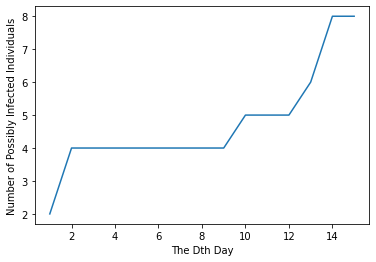

In [181]:
plt.xlabel("The Dth Day")
plt.ylabel("Number of Possibly Infected Individuals")
plt.plot(x_axis,y_axis)

In [262]:
adj_list = defaultdict(list)
edge_map = defaultdict()
infected_list = []
y1_axis = []
x_axis = []
infected_list = ['u1', 'u2']
y2_axis = len(infected_list)
for day in range(1,16):
    n = random.randint(0,10)
    interaction_data = []
    for inter in range(n):
        uid1 = random.randint(1,100)
        x = random.randint(1,100)
        if(x != uid1):
            uid2 = x
        else:
            uid2 = 0
        interaction_data.append(('u' + str(uid1), 'u'+str(uid2)))
        #print(interaction_data
    if day == 1: 
        adj_list, edge_map = updateAdjacencyList(interaction_data, edge_map, adj_list)
    else:
        dailyUpdateEdgeQueue(edge_map)
        adj_list, edge_map = updateAdjacencyList(interaction_data, edge_map, adj_list)
    
    possible_infected = tracingBFS(infected_list, adj_list, edge_map)
    print ("Day", day, len(possible_infected))
    for i in possible_infected: 
        if i not in infected_list:
            infected_list.append(i)
    y1_axis.append(len(possible_infected))
    x_axis.append(day)


Day 1 1
Day 2 6
Day 3 15
Day 4 38
Day 5 42
Day 6 46
Day 7 57
Day 8 64
Day 9 64
Day 10 64
Day 11 64
Day 12 70
Day 13 76
Day 14 78
Day 15 84


In [263]:
y1 = np.array(y1_axis)
#y2 = np.array(y2_axis)
x = np.array(x_axis)

In [264]:
print(y1.shape)
#print(y2.shape)
print(x.shape)

(15,)
(15,)


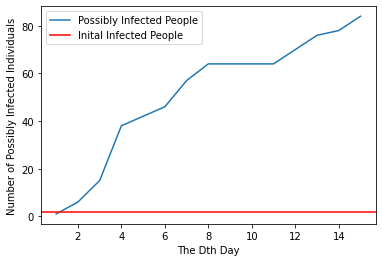

In [267]:
plt.plot(x, y1,  label = "Possibly Infected People")
plt.xlabel("The Dth Day")
plt.ylabel("Number of Possibly Infected Individuals")
plt.axhline(y=2, color='r',label = "Inital Infected People")
plt.legend()
plt.show()

In [280]:
adj_list = defaultdict(list)
edge_map = defaultdict()
infected_list = []
y_axis = []
x_axis = []
infected_list = ['u1', 'u2']
for day in range(1,16):
    n = random.randint(0,4)
    interaction_data = []
    for inter in range(n):
        uid1 = random.randint(0,5)
        uid2 = random.randint(5,10)
        
        interaction_data.append(('u' + str(uid1), 'u'+str(uid2)))
        #print(interaction_data
    if day == 1: 
        adj_list, edge_map = updateAdjacencyList(interaction_data, edge_map, adj_list)
    else:
        dailyUpdateEdgeQueue(edge_map)
        adj_list, edge_map = updateAdjacencyList(interaction_data, edge_map, adj_list)
    
    
    possible_infected = tracingBFS(infected_list, adj_list, edge_map)
    print ("Day", day, len(possible_infected))
    y_axis.append(len(possible_infected))
    x_axis.append(day)
print (adj_list)

Day 1 0
Day 2 0
Day 3 4
Day 4 5
Day 5 5
Day 6 5
Day 7 7
Day 8 7
Day 9 7
Day 10 9
Day 11 9
Day 12 10
Day 13 10
Day 14 10
Day 15 10
defaultdict(<class 'list'>, {'u4': [('u8', 'u4_u8'), ('u7', 'u4_u7'), ('u9', 'u4_u9'), ('u5', 'u4_u5')], 'u8': [('u4', 'u4_u8'), ('u3', 'u3_u8'), ('u2', 'u2_u8')], 'u1': [('u10', 'u1_u10'), ('u7', 'u1_u7'), ('u9', 'u1_u9'), ('u6', 'u1_u6')], 'u2': [('u5', 'u2_u5'), ('u8', 'u2_u8'), ('u6', 'u2_u6')], 'u0': [('u5', 'u0_u5'), ('u6', 'u0_u6'), ('u9', 'u0_u9')], 'u5': [('u0', 'u0_u5'), ('u10', 'u5_u10'), ('u9', 'u5_u9'), ('u2', 'u2_u5'), ('u3', 'u3_u5'), ('u4', 'u4_u5')], 'u10': [('u5', 'u5_u10'), ('u1', 'u1_u10'), ('u3', 'u3_u10')], 'u9': [('u5', 'u5_u9'), ('u1', 'u1_u9'), ('u0', 'u0_u9'), ('u4', 'u4_u9')], 'u3': [('u10', 'u3_u10'), ('u8', 'u3_u8'), ('u5', 'u3_u5'), ('u6', 'u3_u6')], 'u7': [('u1', 'u1_u7'), ('u4', 'u4_u7')], 'u': [], 'u6': [('u0', 'u0_u6'), ('u1', 'u1_u6'), ('u2', 'u2_u6'), ('u3', 'u3_u6')]})


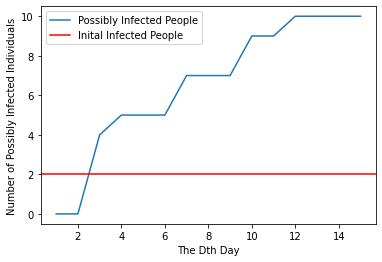

In [281]:
plt.plot(x, y_axis,  label = "Possibly Infected People")
plt.xlabel("The Dth Day")
plt.ylabel("Number of Possibly Infected Individuals")
plt.axhline(y=2, color='r',label = "Inital Infected People")
plt.legend()
plt.show()